In [62]:
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image
from PIL import Image
import matplotlib.pyplot as plt
import requests
import numpy as np
url = "https://picsum.photos/200"
image = load_image(url)

pretrained_model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name,
    device_map="auto",
     output_attentions=True
)

inputs = processor(images=image, return_tensors="pt").to(model.device)
with torch.inference_mode():
    outputs = model(**inputs)

pooled_output = outputs.pooler_output
print("Pooled output shape:", pooled_output.shape)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Pooled output shape: torch.Size([1, 768])


In [70]:
from PIL import ImageGrab

url = "https://picsum.photos/200"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = ImageGrab.grabclipboard()

196
14


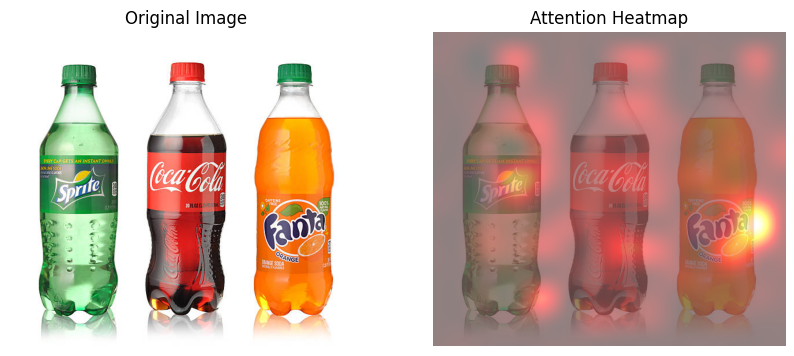

In [79]:
def getAttentionMap(image):
    inputs = processor(images=image, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights (last layer, average across heads)
    attentions = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
    attentions = attentions.mean(dim=1)  # Average across heads: [batch_size, seq_len, seq_len]

    # Get attention scores for the class token (index 0)
    bump = 4
    cls_attention = attentions[0, 0, bump:bump+196]  # Exclude class token self-attention
    num_patches = int(np.sqrt(cls_attention.shape[0]))  # e.g., 14 for 14x14 grid
    print(cls_attention.shape[0])
    print(num_patches)
    attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()

    # Upscale attention map to image size
    from scipy.ndimage import zoom
    attention_map = zoom(attention_map, zoom=(image.size[1] / num_patches, image.size[0] / num_patches))

    # Visualize original image and attention heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.5)
    plt.imshow(attention_map, cmap="hot", alpha=0.5)
    plt.title("Attention Heatmap")
    plt.axis("off")
    plt.show()
getAttentionMap(ImageGrab.grabclipboard())